# Figure 4 (Molina et al. 2022)

## Imports

In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import xskillscore as xs

import som_analysis
import cluster_analysis
import narm_analysis

## functions

In [2]:
def add_insetmap(axes_extent, map_extent, lons, lats, temp_data, 
                 vmin, vmax, cmap='coolwarm'):
    
    use_projection = ccrs.Mercator()     # preserve shape well
    geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))
    
    sub_ax = plt.axes(axes_extent, projection=use_projection)  # normal units
    
    sub_ax.set_extent(map_extent, geodetic)  # map extents
    sub_ax.coastlines(linewidth=0.35, zorder=10)
    
    sub_ax.pcolormesh(lons, lats, temp_data, transform=ccrs.PlateCarree(),
                      vmin=vmin, vmax=vmax, cmap=cmap)

    extent_box = sgeom.box(map_extent[0], map_extent[2], map_extent[1], map_extent[3])
    sub_ax.add_geometries([extent_box], ccrs.PlateCarree(), color='none', linewidth=0.05)

In [3]:
def get_cold_indx(ds, mo_init=9, mo_end=2):
    """
    Extract indices for cold season.
    Grabbing Sept thru February init, for Oct thru March predictions.
    """
    dt_array = pd.to_datetime(ds['time'])
    return xr.where((dt_array.month>=mo_init) | (dt_array.month<=mo_end), True, False)

## open and preprocess data

In [4]:
# region for clustering
lat0=10; lat1=70; lon0=-150; lon1=-40

# open era5 data and slice
ds_era5 = narm_analysis.era5_z500(lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1)

# era5 anomalies
ds_era5_anom = narm_analysis.era5_climo_wrs(ds_era5, rolling_days=5, variable='clim')

# restructure era5 array for machine learning training (SONDJFM)
ds_era5_anom = ds_era5_anom[get_cold_indx(ds_era5_anom, mo_init=10, mo_end=3),...]
ds_era5_train = ds_era5_anom.stack(flat=('lat','lon')).transpose('time','flat').values

## pca and kmeans with era5

In [5]:
# create pca object
pca_obj = PCA(12, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(ds_era5_train)

# transform era5 data with pca
ds_era5_train = pca_obj.transform(ds_era5_train)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(
f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}'
)

# train kmeans
k_means = KMeans(n_clusters=4,
                 init='k-means++',
                 n_init=10000,
                 max_iter=300,
                 tol=0.0001,
                 verbose=0,
                 random_state=0).fit(ds_era5_train)

print(f'inertia: {k_means.inertia_}')

Variance explained: [25.95315607 17.65410568 11.94871708  9.0784389   7.98100848  6.14181738
  4.32605934  2.61658689  2.22642929  2.17049559  1.49813958  1.22541708]
Cumulative sum of variance explained for EOF1 and EOF2: [25.95315607 43.60726175 55.55597883 64.63441774 72.61542622 78.7572436
 83.08330294 85.69988983 87.92631912 90.09681471 91.59495429 92.82037136]
inertia: 39379.20539555194


## load data with lead time bias corrected anomalies

In [6]:
# era5 data
z500_era5, z500_era5_dt = som_analysis.open_era5_files(
    variable='z500', return_time=True, 
    lat0=lat0,lat1=lat1,lon0=lon0,lon1=lon1,
    leadday0=0,leadday1=42,rolldays=5,)

# cesm data
z500_cesm, z500_cesm_dt = som_analysis.open_cesm_files(
    variable='zg_500', return_time=True, 
    lat0=lat0,lat1=lat1,lon0=lon0,lon1=lon1,
    leadday0=0,leadday1=42,rolldays=5,)

# restructure arrays
z500_standard_era5 = z500_era5.stack(
    new=('time','lead'),flat=('lat','lon')).transpose('new','flat')
z500_standard_cesm = z500_cesm.stack(
    new=('time','lead'),flat=('lat','lon')).transpose('new','flat')

## extract cluster labels

(projecting era5 pca and kmeans onto cesm2)

In [7]:
cluster_era5_evo = cluster_analysis.single_clusters(  z500_standard_era5, k_means, pca_obj, use_pca=True)
cluster_cesm_evo = cluster_analysis.single_clusters(  z500_standard_cesm, k_means, pca_obj, use_pca=True)

## Compute skill (daily weather regimes and weather regime weekly frequency)

In [8]:
# acc for all weather regimes (daily)

acc_ = []
for i in range(43):
    acc_.append(stats.pearsonr(
        cluster_era5_evo[0,:,i],cluster_cesm_evo[0,:,i])[0])

# mse for all weather regimes (daily)

mse_ = []
for i in range(43):
    mse_.append(metrics.mean_squared_error(
        cluster_era5_evo[0,:,i],cluster_cesm_evo[0,:,i]))

# acc for individual weather regime frequency (weekly)

acc_wr1 = []; acc_wr2 = []; acc_wr3 = []; acc_wr4 = []
for i in range(4,43-3):
    acc_wr1.append(stats.pearsonr(
        np.sum(cluster_era5_evo[0,:,i-3:i+3+1]==0,axis=1),
        np.sum(cluster_cesm_evo[0,:,i-3:i+3+1]==0,axis=1))[0])
    
    acc_wr2.append(stats.pearsonr(
        np.sum(cluster_era5_evo[0,:,i-3:i+3+1]==1,axis=1),
        np.sum(cluster_cesm_evo[0,:,i-3:i+3+1]==1,axis=1))[0])
    
    acc_wr3.append(stats.pearsonr(
        np.sum(cluster_era5_evo[0,:,i-3:i+3+1]==2,axis=1),
        np.sum(cluster_cesm_evo[0,:,i-3:i+3+1]==2,axis=1))[0])
    
    acc_wr4.append(stats.pearsonr(
        np.sum(cluster_era5_evo[0,:,i-3:i+3+1]==3,axis=1),
        np.sum(cluster_cesm_evo[0,:,i-3:i+3+1]==3,axis=1))[0])
    
# mse for individual weather regime frequency (weekly)

mse_wr1 = []; mse_wr2 = []; mse_wr3 = []; mse_wr4 = []
for i in range(4,43-3):
    mse_wr1.append(metrics.mean_squared_error(
        np.sum(cluster_era5_evo[0,:,i-3:i+3+1]==0,axis=1),
        np.sum(cluster_cesm_evo[0,:,i-3:i+3+1]==0,axis=1)))
    
    mse_wr2.append(metrics.mean_squared_error(
        np.sum(cluster_era5_evo[0,:,i-3:i+3+1]==1,axis=1),
        np.sum(cluster_cesm_evo[0,:,i-3:i+3+1]==1,axis=1)))
    
    mse_wr3.append(metrics.mean_squared_error(
        np.sum(cluster_era5_evo[0,:,i-3:i+3+1]==2,axis=1),
        np.sum(cluster_cesm_evo[0,:,i-3:i+3+1]==2,axis=1)))
    
    mse_wr4.append(metrics.mean_squared_error(
        np.sum(cluster_era5_evo[0,:,i-3:i+3+1]==3,axis=1),
        np.sum(cluster_cesm_evo[0,:,i-3:i+3+1]==3,axis=1)))

In [9]:
boot_num_iter_ = 1000

In [10]:
# acc for all weather regimes (daily)

acc_boot = np.zeros((boot_num_iter_,43))

for i in range(43):
    
    for j in range(boot_num_iter_):

        np.random.seed(j)
        rand_ = [np.random.choice(
            cluster_era5_evo[0,:,i].shape[0]) for k in range(cluster_era5_evo[0,:,i].shape[0])]

        acc_boot[j,i] = stats.pearsonr(cluster_era5_evo[0,rand_,i],cluster_cesm_evo[0,rand_,i])[0]

In [11]:
# mse for all weather regimes (daily)

mse_boot = np.zeros((boot_num_iter_,43))

for i in range(43):
    
    for j in range(boot_num_iter_):
        
        np.random.seed(j)
        rand_ = [np.random.choice(
            cluster_era5_evo[0,:,i].shape[0]) for k in range(cluster_era5_evo[0,:,i].shape[0])]
    
        mse_boot[j,i] = metrics.mean_squared_error(cluster_era5_evo[0,rand_,i],cluster_cesm_evo[0,rand_,i])

In [12]:
# acc for individual weather regime frequency (weekly)

acc_wr1_boot = np.zeros((boot_num_iter_,43-3-4))
acc_wr2_boot = np.zeros((boot_num_iter_,43-3-4))
acc_wr3_boot = np.zeros((boot_num_iter_,43-3-4))
acc_wr4_boot = np.zeros((boot_num_iter_,43-3-4))

for index_, i in enumerate(range(4,43-3)):
    
    for j in range(boot_num_iter_):
        
        np.random.seed(j)
        rand_ = [np.random.choice(
            cluster_era5_evo[0,:,i].shape[0]) for k in range(cluster_era5_evo[0,:,i].shape[0])]
    
        acc_wr1_boot[j,index_] = stats.pearsonr(
            np.sum(cluster_era5_evo[0,rand_,i-3:i+3+1]==0,axis=1),
            np.sum(cluster_cesm_evo[0,rand_,i-3:i+3+1]==0,axis=1))[0]
    
        acc_wr2_boot[j,index_] = stats.pearsonr(
            np.sum(cluster_era5_evo[0,rand_,i-3:i+3+1]==1,axis=1),
            np.sum(cluster_cesm_evo[0,rand_,i-3:i+3+1]==1,axis=1))[0]

        acc_wr3_boot[j,index_] = stats.pearsonr(
            np.sum(cluster_era5_evo[0,rand_,i-3:i+3+1]==2,axis=1),
            np.sum(cluster_cesm_evo[0,rand_,i-3:i+3+1]==2,axis=1))[0]

        acc_wr4_boot[j,index_] = stats.pearsonr(
            np.sum(cluster_era5_evo[0,rand_,i-3:i+3+1]==3,axis=1),
            np.sum(cluster_cesm_evo[0,rand_,i-3:i+3+1]==3,axis=1))[0]

In [ ]:
# mse for individual weather regime frequency (weekly)

mse_wr1_boot = np.zeros((boot_num_iter_,43-3-4))
mse_wr2_boot = np.zeros((boot_num_iter_,43-3-4))
mse_wr3_boot = np.zeros((boot_num_iter_,43-3-4))
mse_wr4_boot = np.zeros((boot_num_iter_,43-3-4))

for index_, i in enumerate(range(4,43-3)):
    
    for j in range(boot_num_iter_):
        
        np.random.seed(j)
        rand_ = [np.random.choice(
            cluster_era5_evo[0,:,i].shape[0]) for k in range(cluster_era5_evo[0,:,i].shape[0])]
    
        mse_wr1_boot[j,index_] = metrics.mean_squared_error(
            np.sum(cluster_era5_evo[0,rand_,i-3:i+3+1]==0,axis=1),
            np.sum(cluster_cesm_evo[0,rand_,i-3:i+3+1]==0,axis=1))

        mse_wr2_boot[j,index_] = metrics.mean_squared_error(
            np.sum(cluster_era5_evo[0,rand_,i-3:i+3+1]==1,axis=1),
            np.sum(cluster_cesm_evo[0,rand_,i-3:i+3+1]==1,axis=1))

        mse_wr3_boot[j,index_] = metrics.mean_squared_error(
            np.sum(cluster_era5_evo[0,rand_,i-3:i+3+1]==2,axis=1),
            np.sum(cluster_cesm_evo[0,rand_,i-3:i+3+1]==2,axis=1))

        mse_wr4_boot[j,index_] = metrics.mean_squared_error(
            np.sum(cluster_era5_evo[0,rand_,i-3:i+3+1]==3,axis=1),
            np.sum(cluster_cesm_evo[0,rand_,i-3:i+3+1]==3,axis=1))

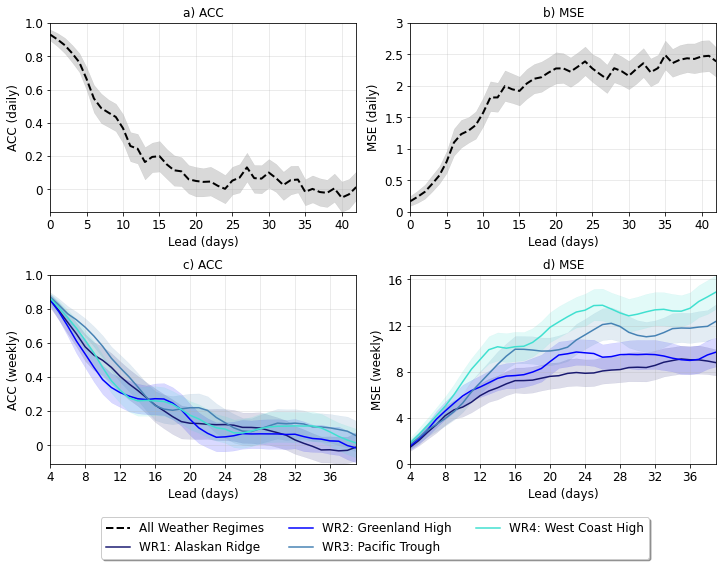

In [19]:
# ---

fig = plt.figure(figsize=(10,7))

# ---

ax1 = plt.axes([0.,0.5,0.425,0.375])

ls0, = ax1.plot(np.arange(0,43,1), acc_, color='k', ls='--', lw=2., zorder=10)

ax1.fill_between(np.arange(0,43,1), 
                 np.nanpercentile(acc_boot,2.5,axis=0),
                 np.nanpercentile(acc_boot,97.5,axis=0), 
                 color='k', ls='-', lw=0.25, alpha=0.15)

ax1.set_title('a) ACC', fontsize=12)

ax1.margins(x=0,y=0)
ax1.grid('--', lw=0.5, alpha=0.5)

ax1.set_xticks([0,5,10,15,20,25,30,35,40])
ax1.set_xticklabels([0,5,10,15,20,25,30,35,40],fontsize=12)
ax1.set_xlabel('Lead (days)',fontsize=12)

ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.])
ax1.set_yticklabels([0,0.2,0.4,0.6,0.8,1.],fontsize=12)
ax1.set_ylabel('ACC (daily)',fontsize=12)

# ---

ax2 = plt.axes([0.5,0.5,0.425,0.375])

ax2.plot(np.arange(0,43,1), mse_, color='k', ls='--', lw=2.)

ax2.fill_between(np.arange(0,43,1), 
                 np.nanpercentile(mse_boot,2.5,axis=0),
                 np.nanpercentile(mse_boot,97.5,axis=0), 
                 color='k', ls='-', lw=0.25, alpha=0.15)

ax2.set_title('b) MSE', fontsize=12)

ax2.margins(x=0,y=0)
ax2.grid('--', lw=0.5, alpha=0.5)

ax2.set_xticks([0,5,10,15,20,25,30,35,40])
ax2.set_xticklabels([0,5,10,15,20,25,30,35,40],fontsize=12)
ax2.set_xlabel('Lead (days)',fontsize=12)

ax2.set_yticks([0,0.5,1,1.5,2,2.5,3])
ax2.set_yticklabels([0,0.5,1,1.5,2,2.5,3],fontsize=12)
ax2.set_ylabel('MSE (daily)',fontsize=12)

# ---

ax3 = plt.axes([0.,0.,0.425,0.375])

ls1, = ax3.plot(np.arange(0,36,1), acc_wr1, color='midnightblue', ls='-', lw=1.5)

ax3.fill_between(np.arange(0,36,1), 
                 np.nanpercentile(acc_wr1_boot,2.5,axis=0),
                 np.nanpercentile(acc_wr1_boot,97.5,axis=0), 
                 color='midnightblue', ls='-', lw=0.25, alpha=0.15)

ls2, = ax3.plot(np.arange(0,36,1), acc_wr2, color='blue', ls='-', lw=1.5)

ax3.fill_between(np.arange(0,36,1), 
                 np.nanpercentile(acc_wr2_boot,2.5,axis=0),
                 np.nanpercentile(acc_wr2_boot,97.5,axis=0), 
                 color='blue', ls='-', lw=0.25, alpha=0.15)

ls3, = ax3.plot(np.arange(0,36,1), acc_wr3, color='steelblue', ls='-', lw=1.5)

ax3.fill_between(np.arange(0,36,1), 
                 np.nanpercentile(acc_wr3_boot,2.5,axis=0),
                 np.nanpercentile(acc_wr3_boot,97.5,axis=0), 
                 color='steelblue', ls='-', lw=0.25, alpha=0.15)

ls4, = ax3.plot(np.arange(0,36,1), acc_wr4, color='turquoise', ls='-', lw=1.5)

ax3.fill_between(np.arange(0,36,1), 
                 np.nanpercentile(acc_wr4_boot,2.5,axis=0),
                 np.nanpercentile(acc_wr4_boot,97.5,axis=0), 
                 color='turquoise', ls='-', lw=0.25, alpha=0.15)

ax3.set_title('c) ACC', fontsize=12)

ax3.margins(x=0,y=0)
ax3.grid('--', lw=0.5, alpha=0.5)

ax3.set_xticks(np.arange(0,35,4))
ax3.set_xticklabels(np.arange(4,39,4),fontsize=12)
ax3.set_xlabel('Lead (days)',fontsize=12)

ax3.set_yticks([0,0.2,0.4,0.6,0.8,1.])
ax3.set_yticklabels([0,0.2,0.4,0.6,0.8,1.],fontsize=12)
ax3.set_ylabel('ACC (weekly)',fontsize=12)

# ---

ax4 = plt.axes([0.5,0.,0.425,0.375])

ax4.plot(np.arange(0,36,1), mse_wr1, color='midnightblue', ls='-', lw=1.5)

ax4.fill_between(np.arange(0,36,1), 
                 np.nanpercentile(mse_wr1_boot,2.5,axis=0),
                 np.nanpercentile(mse_wr1_boot,97.5,axis=0), 
                 color='midnightblue', ls='-', lw=0.25, alpha=0.15)

ax4.plot(np.arange(0,36,1), mse_wr2, color='blue', ls='-', lw=1.5)

ax4.fill_between(np.arange(0,36,1), 
                 np.nanpercentile(mse_wr2_boot,2.5,axis=0),
                 np.nanpercentile(mse_wr2_boot,97.5,axis=0), 
                 color='blue', ls='-', lw=0.25, alpha=0.15)

ax4.plot(np.arange(0,36,1), mse_wr3, color='steelblue', ls='-', lw=1.5)

ax4.fill_between(np.arange(0,36,1), 
                 np.nanpercentile(mse_wr3_boot,2.5,axis=0),
                 np.nanpercentile(mse_wr3_boot,97.5,axis=0), 
                 color='steelblue', ls='-', lw=0.25, alpha=0.15)

ax4.plot(np.arange(0,36,1), mse_wr4, color='turquoise', ls='-', lw=1.5)

ax4.fill_between(np.arange(0,36,1), 
                 np.nanpercentile(mse_wr4_boot,2.5,axis=0),
                 np.nanpercentile(mse_wr4_boot,97.5,axis=0), 
                 color='turquoise', ls='-', lw=0.25, alpha=0.15)

ax4.set_title('d) MSE', fontsize=12)

ax4.margins(x=0,y=0)
ax4.grid('--', lw=0.5, alpha=0.5)

ax4.set_xticks(np.arange(0,35,4))
ax4.set_xticklabels(np.arange(4,39,4),fontsize=12)
ax4.set_xlabel('Lead (days)',fontsize=12)

ax4.set_yticks([0,4,8,12,16])
ax4.set_yticklabels([0,4,8,12,16],fontsize=12)
ax4.set_ylabel('MSE (weekly)',fontsize=12)

ax4.legend([ls0,ls1,ls2,ls3,ls4],
           ['All Weather Regimes',
            'WR1: Alaskan Ridge',
            'WR2: Greenland High',
            'WR3: Pacific Trough',
            'WR4: West Coast High'],
           ncol=3, bbox_to_anchor=(0.8, -0.25), 
           fancybox=True, shadow=True, fontsize=12)

# ---

plt.savefig(f"fig_eval.png", bbox_inches='tight', dpi=500)
plt.show()

# ---